<a href="https://colab.research.google.com/github/saiki050/signate_financial/blob/main/%E5%82%B5%E5%8B%99%E4%B8%8D%E5%B1%A5%E8%A1%8C%E4%BA%88%E6%B8%AC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
"""
### pycaretの環境構築に毎回時間がかかる。gitからinstallするやり方で行い、ランタイムの再起動をすること。
!pip install git+https://github.com/pycaret/pycaret.git@master --upgrade -q
# print("pycaret version: ", pycaret.__version__)
"""

'\n### pycaretの環境構築に毎回時間がかかる。gitからinstallするやり方で行い、ランタイムの再起動をすること。\n!pip install git+https://github.com/pycaret/pycaret.git@master --upgrade -q\n# print("pycaret version: ", pycaret.__version__)\n'

In [30]:
from google.colab import drive
drive.mount('/content/drive')  #listになかったのでドライブ上にデータ保存し、ドライブをマウント。

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#GooglecolabでAPI認証する

#!pip install signate

from googleapiclient.discovery import build
import io, os
from googleapiclient.http import MediaIoBaseDownload
from google.colab import auth


auth.authenticate_user()

drive_service = build('drive', 'v3')
results = drive_service.files().list(
        q="name = 'signate.json'", fields="files(id)").execute()
signate_api_key = results.get('files', [])

filename = "/root/.signate/signate.json"
os.makedirs(os.path.dirname(filename), exist_ok=True)

request = drive_service.files().get_media(fileId=signate_api_key[0]['id'])
fh = io.FileIO(filename, 'wb')
downloader = MediaIoBaseDownload(fh, request)
done = False
while done is False:
    status, done = downloader.next_chunk()
    print("Download %d%%." % int(status.progress() * 100))
os.chmod(filename, 600)


In [ ]:
# signateインストール
!pip install signate
#signateのAPI利用
! signate token --email=chaigucci2@gmail.com --password=02281299TGtg

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9655 sha256=1f6655fbf4d1abba6e833bbc6315c1ca61cdfbe07fcd607fe6dc0cd58f437657
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget
The API Token has been downloaded successfully.


In [ ]:
! signate list

  competitionId  title                                                                             closing     prize           submitters
---------------  --------------------------------------------------------------------------------  ----------  ------------  ------------
              1  【練習問題】銀行の顧客ターゲティング                                              -                                 6976
             24  【練習問題】お弁当の需要予測                                                      -                                 8449
             27  【練習問題】Jリーグの観客動員数予測                                               -                                 2068
            100  【練習問題】手書き文字認識                                                        -           Knowledge              341
            102  【練習問題】タイタニックの生存予測                                                -           Knowledge             2614
            103  【練習問題】音楽ラベリング                                                        -           Knowledge      

In [ ]:
! signate files --competition-id=1337

  fileId  name                   title                      size  updated_at
--------  ---------------------  ----------------------  -------  -------------------
    3877  train.csv              学習用データ            4916051  2024-01-13 16:04:02
    3878  test.csv               評価用データ            4842723  2024-01-13 16:05:59
    3879  sample_submission.csv  投稿用サンプルファイル   338464  2024-01-13 16:15:39


In [ ]:
#上で確認したファイルがディレクトリに存在しなければ保存
if not os.path.exists('/content/drive/MyDrive/Colab Notebooks/signate_financial/train.csv'):
    ! signate download --competition-id=1337

In [ ]:
#ベースライン作成開始

import numpy as np
import pandas as pd
import re
import pickle
import gc
import matplotlib.pyplot as plt
import zipfile
import os

# scikit-learn
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score

import seaborn as sns
# LightGBM
import lightgbm as lgb

from sklearn.linear_model import LogisticRegression
from imblearn.under_sampling import InstanceHardnessThreshold
from imblearn.over_sampling import ADASYN, BorderlineSMOTE, KMeansSMOTE, RandomOverSampler, SMOTE, SMOTENC, SVMSMOTE
import lightgbm as lgb # LightGBM
from tqdm import tqdm # プログレスバー
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, matthews_corrcoef, precision_score, recall_score
from scipy import stats


In [ ]:
pd.set_option('display.max_columns', None)

In [ ]:
#メモリ削減関数

def reduce_mem_usage(df):
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtype

        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            pass

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df

In [ ]:
application_train = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/signate_financial/train.csv", index_col=0)
application_test = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/signate_financial/test.csv", index_col=0)
sample_submission = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/signate_financial/sample_submission.csv", header=None)

In [ ]:
display(application_train)

,Term,NoEmp,NewExist,CreateJob,RetainedJob,FranchiseCode,RevLineCr,LowDoc,DisbursementDate,MIS_Status,Sector,ApprovalDate,ApprovalFY,City,State,BankState,DisbursementGross,GrAppv,SBA_Appv,UrbanRural
0,163,21,1.0,0,0,1,N,N,31-Jan-98,1,0,22-Sep-06,2006,PHOENIX,AZ,SD,"$80,000.00","$80,000.00","$68,000.00",0
1,84,6,1.0,4,0,0,0,N,31-Oct-93,1,62,30-Jun-92,1992,MCALESTER,OK,OK,"$287,000.00","$287,000.00","$229,600.00",0
2,242,45,1.0,4,90,0,N,N,31-Aug-01,1,42,18-Apr-01,2001,HAWTHORNE,NJ,NJ,"$31,983.00","$30,000.00","$15,000.00",1
3,237,4,1.0,0,0,0,N,N,31-Aug-07,1,33,6-Oct-03,2004,NASHVILLE,TN,SD,"$229,000.00","$229,000.00","$229,000.00",0
4,184,0,1.0,0,0,0,N,N,8-Jun-83,1,0,17-Dec-99,2000,POMONA,CA,CA,"$525,000.00","$525,000.00","$393,750.00",0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42302,283,14,1.0,0,0,1,N,N,31-Jan-98,1,0,2-Mar-95,1995,PHILADELPHIA,PA,PA,"$80,000.00","$80,000.00","$68,000.00",0
42303,53,2,1.0,0,0,0,Y,N,3-Apr-91,1,42,6-Jun-07,2007,LOS ANGELES,CA,SD,"$5,000.00","$5,000.00","$4,250.00",1
42304,59,6,2.0,0,0,1,N,N,28-Feb-03,1,42,14-Mar-03,2003,COLUMBUS,OH,OH,"$60,000.00","$60,000.00","$51,000.00",0
42305,295,18,1.0,0,8,0,N,N,10-Dec-97,1,42,23-Aug-89,1989,CLOQUET,MN,MN,"$294,000.00","$294,000.00","$220,500.00",0


In [ ]:
cp_train = application_train.copy()
cp_test = application_test.copy()

In [ ]:
print(cp_test.shape)
print(cp_train.shape)

(42308, 19)
(42307, 20)


In [ ]:
### メモリ削減関数実行
mem_train = reduce_mem_usage(cp_train)
mem_test = reduce_mem_usage(cp_test)

Memory usage of dataframe is 6.78 MB
Memory usage after optimization is: 4.28 MB
Decreased by 36.9%
Memory usage of dataframe is 6.46 MB
Memory usage after optimization is: 4.24 MB
Decreased by 34.4%


In [ ]:
print(mem_train.isnull().sum()) #nullの数
print(mem_train.nunique()) #uniqueの数

Term                    0
NoEmp                   0
NewExist                0
CreateJob               0
RetainedJob             0
FranchiseCode           0
RevLineCr            1079
LowDoc                531
DisbursementDate      150
MIS_Status              0
Sector                  0
ApprovalDate            0
ApprovalFY              0
City                    0
State                   0
BankState              11
DisbursementGross       0
GrAppv                  0
SBA_Appv                0
UrbanRural              0
dtype: int64
Term                  228
NoEmp                 196
NewExist                2
CreateJob              49
RetainedJob            83
FranchiseCode         271
RevLineCr               4
LowDoc                  6
DisbursementDate      916
MIS_Status              2
Sector                 24
ApprovalDate         3868
ApprovalFY             38
City                 2703
State                  51
BankState              51
DisbursementGross    2694
GrAppv               1425

**EDA(前処理)**

日付をdatetimeに変換

In [ ]:
# 各列を日時オブジェクトに変換
mem_train['DisbursementDate'] = pd.to_datetime(mem_train['DisbursementDate'], format='%d-%b-%y')
mem_train['ApprovalDate'] = pd.to_datetime(mem_train['ApprovalDate'], format='%d-%b-%y')
# テストも
mem_test['DisbursementDate'] = pd.to_datetime(mem_test['DisbursementDate'], format='%d-%b-%y')
mem_test['ApprovalDate'] = pd.to_datetime(mem_test['ApprovalDate'], format='%d-%b-%y')

$を取り除く

In [ ]:
# trainデータ
mem_train[['DisbursementGross',  'GrAppv', 'SBA_Appv']] =\
mem_train[['DisbursementGross',  'GrAppv', 'SBA_Appv']].applymap(lambda x: x.strip().replace('$', '').replace(',', ''))
#testデータも同様に変換
mem_test[['DisbursementGross',  'GrAppv', 'SBA_Appv']]= \
mem_test[['DisbursementGross',  'GrAppv', 'SBA_Appv']].applymap(lambda x: x.strip().replace('$', '').replace(',', ''))

mem_train[['DisbursementGross',  'GrAppv', 'SBA_Appv']].head()

,DisbursementGross,GrAppv,SBA_Appv
0,80000.00,80000.00,68000.00
1,287000.00,287000.00,229600.00
2,31983.00,30000.00,15000.00
3,229000.00,229000.00,229000.00
4,525000.00,525000.00,393750.00


In [ ]:
### 数値に変換
mem_train[['DisbursementGross',  'GrAppv', 'SBA_Appv']] = mem_train[['DisbursementGross',  'GrAppv', 'SBA_Appv']].astype(float)
mem_test[['DisbursementGross',  'GrAppv', 'SBA_Appv']] = mem_test[['DisbursementGross',  'GrAppv', 'SBA_Appv']].astype(float)

In [ ]:
### 各特徴量が正規分布に従うか判断し、表示する関数、赤線に沿っていれば正規分布
# 描画設定
from matplotlib import rcParams
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

def plot_qq_plots(dataframe, columns):
    sns.set_style("whitegrid")
    rcParams['xtick.labelsize'] = 12
    rcParams['ytick.labelsize'] = 12
    rcParams['axes.labelsize'] = 18
    rcParams['figure.figsize'] = 18, 8

    # 列数に基づいて行数を計算
    num_columns = len(columns)
    num_rows = (num_columns + 2) // 3

    # サブプロットの作成
    fig, axs = plt.subplots(num_rows, 3, figsize=(15, 5 * num_rows))

    for i, col in enumerate(columns):
        if col not in dataframe.columns:
            print(f"Warning: '{col}' does not exist in the dataframe.")
            continue
        if dataframe[col].dropna().empty:
            print(f"Warning: '{col}' has no data.")
            continue

        ax = axs[i // 3, i % 3]
        stats.probplot(dataframe[col].dropna(), dist="norm", plot=ax)
        ax.set_title(col)

    # 空のサブプロットを非表示
    for j in range(i + 1, num_rows * 3):
        fig.delaxes(axs[j // 3, j % 3])

    plt.tight_layout()
    plt.show()

In [ ]:
### 数値データだけを取り出し、正規性があるか確かめる。
numeric_col = []
for col in mem_train.columns:
  if mem_train[col].dtype != 'object':     #object型以外のカラム取得
    numeric_col.append(col)

In [ ]:
numeric_col #数値データだけのカラム

['Term',
 'NoEmp',
 'NewExist',
 'CreateJob',
 'RetainedJob',
 'FranchiseCode',
 'DisbursementDate',
 'MIS_Status',
 'Sector',
 'ApprovalDate',
 'ApprovalFY',
 'DisbursementGross',
 'GrAppv',
 'SBA_Appv',
 'UrbanRural']

In [ ]:
# 実行
# plot_qq_plots(mem_train, numeric_col)

特徴量同士の相関のヒートマップ

In [ ]:
# 特徴量同士の相関のヒートマップの関数
# train[std_columns] の相関行列を求める
def show_corr(df, numeric_columns):
  corr_matrix = df[numeric_columns].corr()
  # 相関行列を図示plt.figure(figsize=(10, 8))
  sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
  plt.title('Correlation Matrix of Standardized Columns')
  return plt.show()

In [ ]:
# 実行
# show_corr(mem_train, numeric_col)

**特徴量エンジニアリング**

In [ ]:
eng_train = mem_train.copy()
eng_test = mem_test.copy()

フランチャイズか否かを追加

In [ ]:
### フランチャイズか否かを追加
# 新しい列 'Franchise_YN' を作成し、条件に基づいて値を設定
eng_train['Franchise_Not'] = eng_train['FranchiseCode'].apply(lambda x: x == 1 or x == 0)
eng_test['Franchise_Not'] = eng_test['FranchiseCode'].apply(lambda x: x == 1 or x == 0)

In [ ]:
eng_train['Franchise_Not'].value_counts()

True     40425
False     1882
Name: Franchise_Not, dtype: int64

セクターの0をnanにする

In [ ]:
def sector_nan(df):
  df["Sector"] = df["Sector"].astype(float)
  df['Sector'] = df['Sector'].replace(0, np.nan)
  return df

eng_train = sector_nan(eng_train)
eng_test = sector_nan(eng_test)

ターゲットエンコーディング

In [ ]:
### ターゲットエンコーディング
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

def get_kfold(train, n_splits, seed):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=seed)
    fold_series = []
    for fold, (idx_train, idx_valid) in enumerate(kf.split(train)):
        fold_series.append(pd.Series(fold, index=idx_valid))
    fold_series = pd.concat(fold_series).sort_index()
    return fold_series

def get_targetencoding(train, test, folds: pd.Series, col: str, target):
    for fold in folds.unique():
        idx_train, idx_valid = (folds!=fold), (folds==fold)
        group = train[idx_train].groupby(col)[target].mean().to_dict()
        train.loc[idx_valid, f'target_{col}'] = train.loc[idx_valid, col].map(group)
    group = train.groupby(col)[target].mean().to_dict()
    test[f'target_{col}'] = test[col].map(group)
    return train, test


In [ ]:
def to_target(df_train, df_test, exclude_columns, target="None"):
  nunique = df_train.nunique()
  types = df_train.dtypes

  # KFoldクロスバリデーションの設定
  n_splits = 5
  seed = 42
  folds = get_kfold(df_train, n_splits, seed)

  encode_col = []

  for col in df_train.columns:
    # 特定のカラムの処理を飛ばす
    if col in exclude_columns:
        continue

    # カテゴリカルデータとして扱う条件
    if types[col] == 'object' or nunique[col] < 200:
        encode_col.append(col) #ターゲットエンコーディングするカラム

  #カラム全てに対してエンコ
  for col in encode_col:
    train_encoded, test_encoded = get_targetencoding(df_train, df_test, folds, col, target)

  return train_encoded, test_encoded, encode_col

In [ ]:
#実行
beside_col = ["DisbursementDate","ApprovalDate", "MIS_Status"]
train_encoded, test_encoded, encoded_col = to_target(eng_train, eng_test, beside_col, target="MIS_Status")

場合によりラベルエンコ

In [ ]:
### objectをカテゴリ化(LabelEncoding)
from sklearn.preprocessing import LabelEncoder

def to_cat_data(df, exclude_columns):
    nunique = df.nunique()
    types = df.dtypes

    numerical_columns = []

    for col in df.columns:
        # 特定のカラムの処理を飛ばす
        if col in exclude_columns:
            continue

        # カテゴリカルデータとして扱う条件
        if types[col] == 'object' or nunique[col] < 200:
            print(col, df[col].nunique())

            # NaNを一意のカテゴリとして扱う
            df[col] = df[col].fillna("VV_likely")

            # カラムが文字列型でない場合は文字列に変換
            df[col] = df[col].astype(str)

            # Label Encoding
            l_enc = LabelEncoder()
            df[col] = l_enc.fit_transform(df[col])

        else:
            numerical_columns.append(col)

    return df

# 使用例
# df, num_cols = preprocess_data(df, exclude_columns)

In [ ]:
kari_train = mem_train.copy()
kari_train.query("ApprovalDate == '22-Sep-06' and State == 'AZ'")

# 日付でソートし、最初の行を取得
oldest_data = kari_train.sort_values(by='DisbursementDate').iloc[0]
oldest_data

Term                                 303
NoEmp                                 18
NewExist                             1.0
CreateJob                             11
RetainedJob                            0
FranchiseCode                          0
RevLineCr                              N
LowDoc                                 N
DisbursementDate     1973-12-06 00:00:00
MIS_Status                             1
Sector                                44
ApprovalDate         2000-03-07 00:00:00
ApprovalFY                          2000
City                               TULSA
State                                 OK
BankState                             CA
DisbursementGross              1000000.0
GrAppv                         1200000.0
SBA_Appv                        750000.0
UrbanRural                             0
Name: 18256, dtype: object

SBAが保証する金額と銀行が貸し付けた金額の比(上限の中でどれだけ借りたか)

In [ ]:
mem_train.nunique()

Term                  228
NoEmp                 196
NewExist                2
CreateJob              49
RetainedJob            83
FranchiseCode         271
RevLineCr               4
LowDoc                  6
DisbursementDate      916
MIS_Status              2
Sector                 24
ApprovalDate         3868
ApprovalFY             38
City                 2703
State                  51
BankState              51
DisbursementGross    2694
GrAppv               1425
SBA_Appv             2005
UrbanRural              3
dtype: int64

In [ ]:
mem_train.head()

,Term,NoEmp,NewExist,CreateJob,RetainedJob,FranchiseCode,RevLineCr,LowDoc,DisbursementDate,MIS_Status,Sector,ApprovalDate,ApprovalFY,City,State,BankState,DisbursementGross,GrAppv,SBA_Appv,UrbanRural
0,163,21,1.0,0,0,1,N,N,1998-01-31,1,0,2006-09-22,2006,PHOENIX,AZ,SD,80000.0,80000.0,68000.0,0
1,84,6,1.0,4,0,0,0,N,1993-10-31,1,62,1992-06-30,1992,MCALESTER,OK,OK,287000.0,287000.0,229600.0,0
2,242,45,1.0,4,90,0,N,N,2001-08-31,1,42,2001-04-18,2001,HAWTHORNE,NJ,NJ,31983.0,30000.0,15000.0,1
3,237,4,1.0,0,0,0,N,N,2007-08-31,1,33,2003-10-06,2004,NASHVILLE,TN,SD,229000.0,229000.0,229000.0,0
4,184,0,1.0,0,0,0,N,N,1983-06-08,1,0,1999-12-17,2000,POMONA,CA,CA,525000.0,525000.0,393750.0,0


**最終成形**

In [ ]:
###　日付を分ける
def split_date(df, date_column):
    # 日付データを年、月、日に分割
    df[f'{date_column}_Year'] = df[date_column].dt.year
    df[f'{date_column}_Month'] = df[date_column].dt.month
    df[f'{date_column}_Day'] = df[date_column].dt.day
    return df

eng_fin_train = split_date(mem_train, "DisbursementDate")
eng_fin_train = split_date(eng_fin_train, "ApprovalDate")
eng_fin_test = split_date(mem_test, "DisbursementDate")
eng_fin_test = split_date(eng_fin_test, "ApprovalDate")

In [ ]:
### カテゴリ化(label encode) "City",	"State",	"BankState"のみ
exclude_columns = eng_fin_test.columns.drop(["RevLineCr",	"LowDoc", "City",	"State",	"BankState"])

eng_fin_train = to_cat_data(eng_fin_train, exclude_columns)
eng_fin_test = to_cat_data(eng_fin_test, exclude_columns)

RevLineCr 4
LowDoc 6
MIS_Status 2
State 51
BankState 52
RevLineCr 4
LowDoc 6
State 51
BankState 53


In [ ]:
### datetime削除
eng_fin_train = eng_fin_train.drop(["DisbursementDate", "ApprovalDate"], axis=1)
eng_fin_test = eng_fin_test.drop(["DisbursementDate", "ApprovalDate"], axis=1)

**lightgbmで推論**

In [ ]:
!pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.4/413.4 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 7.7 MB/s eta 0:00:00


In [ ]:
import lightgbm as lgbm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold, StratifiedKFold
from optuna import integration, logging

ModuleNotFoundError: No module named 'optuna'

In [ ]:
def tune_lgbm_params(train, cols_exp, col_target):
    params = {
       "random_seed": 0,
       "objective": 'binary',
       "metric": "binary_logloss",
       'verbose': -1
    }

    x = train[cols_exp].to_numpy()
    y = train[col_target].to_numpy()

    # dataset
    train_set = integration.lightgbm.Dataset(x, y)

    # tuning with optuna
    kf = KFold(n_splits=5, shuffle=True, random_state=0)
    tuner = integration.lightgbm.LightGBMTunerCV(params=params,
                                                train_set=train_set,
                                                num_boost_round=100,
                                                # num_boost_round=5,
                                                folds=kf)

    logging.set_verbosity(logging.WARNING)
    tuner.run()

    params_tuned = tuner.best_params
    return params_tuned

In [ ]:
def train_lgbm(train, cols_exp, col_target, params=None):

    if params is None:
        params = {}

    params_add = {
       "n_estimators": 10000,
       "objective": 'binary',
       "metric": "binary_logloss",
    }
    params |= params_add

    x = train[cols_exp].to_numpy()
    y = train[col_target].to_numpy()

    # K-fold
    kf = KFold(n_splits=5, shuffle=True, random_state=0)
    y_valid_pred_lst = []
    idx_valid_lst = []
    clf_lst = []

    # cross validation
    for fold, (idx_train, idx_valid) in enumerate(kf.split(x)):
        print("fold", fold)
        x_train = x[idx_train, :]
        x_valid = x[idx_valid, :]
        y_train = y[idx_train]
        y_valid = y[idx_valid]

        # lightgbm modeling
        clf = lgbm.LGBMClassifier(**params)
        clf.fit(x_train, y_train,
                eval_set=[(x_train, y_train), (x_valid, y_valid)],
                callbacks=[
                    lgbm.early_stopping(stopping_rounds=50),
                    lgbm.log_evaluation(period=10000),
                ])

        # oof
        y_valid_pred = clf.predict_proba(x_valid)
        y_valid_pred_lst.append(y_valid_pred)
        idx_valid_lst.append(idx_valid)
        clf_lst.append(clf)

    idx_valid = np.hstack(idx_valid_lst)
    y_valid_pred = np.vstack(y_valid_pred_lst)
    oof_pred = y_valid_pred[np.argsort(idx_valid)]

    return clf_lst, oof_pred

In [ ]:
def predict_test(x_test, clf_lst):
    y_test_pred_lst = []

    for clf in clf_lst:
        y_test_pred = clf.predict_proba(x_test)
        y_test_pred_lst.append(y_test_pred)

    y_test_pred = np.mean(y_test_pred_lst, axis=0)
    return y_test_pred

In [ ]:
### 実行
tr = eng_fin_train.copy()
test = eng_fin_test.copy()

cols_exp = [c for c in test.columns if c != "idx"]

col_target = "MIS_Status"
print("col_target =", col_target, "-"*50)

# parameter tuning with optuna
params_tuned = tune_lgbm_params(tr, cols_exp, col_target)

# train LGBM model
clf_lst, oof_pred = train_lgbm(tr, cols_exp, col_target, params_tuned)

# predict test with CV ensemble
y_test_pred = predict_test(test[cols_exp].to_numpy(), clf_lst)

col_target = MIS_Status --------------------------------------------------




  0%|          | 0/7 [00:00<?, ?it/s]

feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]

feature_fraction, val_score: 0.280557:   0%|          | 0/7 [00:02<?, ?it/s]

feature_fraction, val_score: 0.280557:  14%|#4        | 1/7 [00:02<00:17,  2.88s/it]

feature_fraction, val_score: 0.280557:  14%|#4        | 1/7 [00:02<00:17,  2.88s/it]

feature_fraction, val_score: 0.280557:  14%|#4        | 1/7 [00:05<00:17,  2.88s/it]

feature_fraction, val_score: 0.280557:  29%|##8       | 2/7 [00:05<00:14,  2.88s/it]

feature_fraction, val_score: 0.280557:  29%|##8       | 2/7 [00:05<00:14,  2.88s/it]

feature_fraction, val_score: 0.279286:  29%|##8       | 2/7 [00:10<00:14,  2.88s/it]

feature_fraction, val_score: 0.279286:  43%|####2     | 3/7 [00:10<00:15,  3.85s/it]

feature_fraction, val_score: 0.279286:  43%|####2     | 3/7 [00:10<00:15,  3.85s/it]

feature_fraction, val_score: 0.279286:  43%|####2     | 3/7 [00:13<00:15,  3.85s/it]

feature_fraction, val_score: 0.279

fold 0
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[98]	training's binary_logloss: 0.250437	valid_1's binary_logloss: 0.280106
fold 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[92]	training's binary_logloss: 0.253124	valid_1's binary_logloss: 0.275636
fold 2
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[65]	training's binary_logloss: 0.260162	valid_1's binary_logloss: 0.273512
fold 3
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[63]	training's binary_logloss: 0.257958	valid_1's binary_logloss: 0.283378
fold 4
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[84]	training's binary_logloss: 0.254691	valid_1's binary_logloss: 0.275208


ValueError: Shape of passed values is (42307, 2), indices imply (42307, 3)

In [ ]:
# oof_pred_dfを作成
oof_pred_df = pd.DataFrame(oof_pred, columns=[f"MIS_Status{h}" for h in range(2)])
# test_pred_dfを作成
test_pred_df = pd.DataFrame(y_test_pred, columns=[f"MIS_Status{h}" for h in range(2)])

In [ ]:
test_pred_df

,MIS_Status0,MIS_Status1
0,0.728294,0.271706
1,0.036566,0.963434
2,0.385740,0.614260
3,0.098672,0.901328
4,0.047957,0.952043
...,...,...
42303,0.041813,0.958187
42304,0.060152,0.939848
42305,0.078291,0.921709
42306,0.054152,0.945848


In [ ]:
### 重要度可視化
for model in clf_lst:
    fig, ax = plt.subplots(figsize=(10, 15))
    lgbm.plot_importance(model, ignore_zero=False, ax=ax)
    ax.set_yticks(np.arange(len(cols_exp)), np.array(cols_exp)[np.argsort(model.feature_importances_)])
    plt.show()
    plt.close()

本番の推論

In [ ]:
model = lgb.train(params_lgb, train_data, valid_sets=[test_data])

正解ラベルから割合を求めて予測ラベルの確率を変更する

In [ ]:
weights_true = np.array(mem_train["MIS_Status"].value_counts().sort_index()) / len(mem_train)
weights_true

array([0.10731085, 0.89268915])

予測確率を変更し、可視化

In [ ]:
def threshold_tuning_binary(pred_df, dp_lst, weights_true):
    rec = []
    for dp in tqdm(dp_lst):
        # 予測確率を補正
        dp_df = pred_df.copy()
        dp_df['MIS_Status0'] = dp_df['MIS_Status0'] + dp
        dp_df['MIS_Status1'] = dp_df['MIS_Status1'] - (dp * 5)  ### 1ラベルを2.3倍減少させる

        # 補正した予測確率に基づくクラス分類
        pred_label = np.argmax(dp_df[['MIS_Status0', 'MIS_Status1']].values, axis=1)

        # 各クラスに属するデータ件数率を求める
        weights_pred = np.array([(pred_label == h).sum() for h in range(2)]) / len(dp_df)

        # train/testのデータ件数率の絶対誤差
        err = np.abs(weights_true - weights_pred).sum()

        rec.append([dp, err])

    # to dataframe
    rec_df = pd.DataFrame(rec, columns=["dp", "err"])

    # 最適パラメータの特定
    min_err = rec_df['err'].min()
    dp_opt = rec_df[rec_df['err'] == min_err]['dp'].values[0]

    # visualize
    plt.figure(figsize=(6, 4))
    plt.plot(rec_df['dp'], rec_df['err'], label='Error')
    plt.scatter(dp_opt, min_err, color="r", label=f"min_loss: dp = {dp_opt:.5f}")
    plt.xlabel("dp")
    plt.ylabel("Error")
    plt.legend()
    plt.grid()
    plt.show()

    return dp_opt


100%|██████████| 200/200 [00:00<00:00, 316.59it/s]


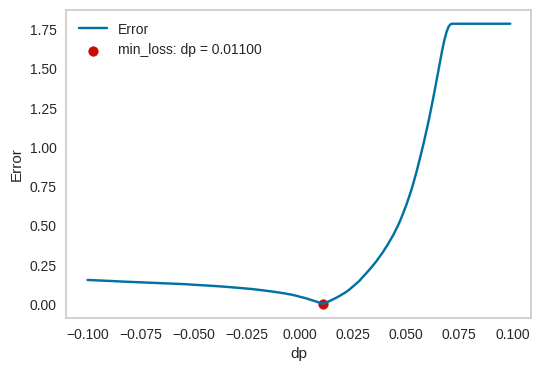

'\n# cv score\nf1 = f1_score(mem_train["MIS_Status"], pred_label, average="macro")\nprint("CV score: f1 =", f1)\n'

In [ ]:
from sklearn.metrics import f1_score

# 解像度の設定
dp_lst = np.arange(-0.1, 0.1, 1e-3)  # 適切な範囲に調整してください

# F1スコア期待値が最大になる確率補正値を探索
dp_opt = threshold_tuning_binary(test_pred_df, dp_lst, weights_true)

# 予測確率を補正
test_pred_df['MIS_Status0'] += dp_opt
test_pred_df['MIS_Status1'] -= dp_opt

# スライドした閾値に基づくクラス分類
pred_label = np.argmax(test_pred_df[['MIS_Status0', 'MIS_Status1']].values, axis=1)

"""
# cv score
f1 = f1_score(mem_train["MIS_Status"], pred_label, average="macro")
print("CV score: f1 =", f1)
"""

In [ ]:
# ユニークな要素とその出現回数を取得
unique_elements, counts = np.unique(pred_label, return_counts=True)

# ユニークな要素の割合を計算
percentages = 100 * counts / len(pred_label)

# 結果を表示
for element, percentage in zip(unique_elements, percentages):
    print(f"Element {element} occurs {percentage:.2f}% of the time.")

Element 0 occurs 9.08% of the time.
Element 1 occurs 90.92% of the time.


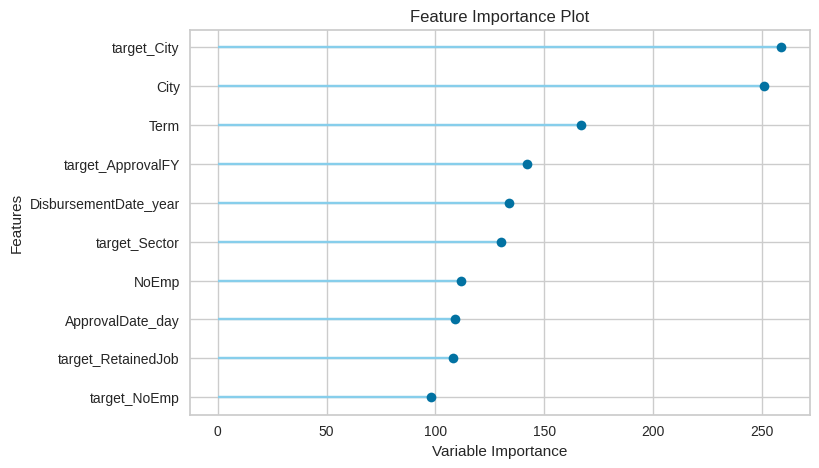

In [ ]:
from pycaret.classification import plot_model

# 特徴量重要度のプロット
plot_model(tuned_lgb, plot = 'feature')

**ファイル提出**

In [ ]:
sample_submission

,0,1
0,42307,0
1,42308,0
2,42309,1
3,42310,0
4,42311,1
...,...,...
42303,84610,0
42304,84611,1
42305,84612,0
42306,84613,1


In [ ]:
###提出ファイルの作成
fin_pred = pd.DataFrame(pred_label, columns=['1'])
combined_df = pd.concat([sample_submission[0], fin_pred], axis=1)
combined_df.columns = range(combined_df.shape[1])

# インデックスをリセット（必要に応じて古いインデックスを削除）
combined_fin_df = combined_df.reset_index(drop=True)

In [ ]:
#提出ファイル出力
combined_fin_df.to_csv('/content/drive/MyDrive/Colab Notebooks/signate_financial/submit4.csv', index=False)

In [ ]:
a = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/signate_financial/submit4.csv')
a

,0,1
0,42307,0
1,42308,1
2,42309,0
3,42310,1
4,42311,1
...,...,...
42303,84610,1
42304,84611,1
42305,84612,1
42306,84613,1


In [ ]:
!git add .
!git commit -m "コミットメッセージ"
!git push origin main

[main 3f2c76e] コミットメッセージ
 5 files changed, 176273 insertions(+)
 create mode 100644 logs.log
 create mode 100644 submit1.csv
 create mode 100644 submit2.csv
 create mode 100644 submit3.csv
 create mode 100644 submit4.csv
fatal: could not read Username for 'https://github.com': No such device or address
